In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt


In [2]:
import os
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# 設定參數

In [3]:
# Read the dataset
df = pd.read_csv(r"C:\Users\user\OneDrive\桌面\研究所\課程內容\遞迴神經網路與變形器\HW1\AI_Human.csv\AI_Human.csv")

In [4]:
# # 計算MAX_VOCAB_SIZE

# # Tokenize
# all_words = [word for text in df['text'] for word in text.split()]
# word_counts = Counter(all_words)

# # 計算累積詞頻
# sorted_counts = sorted(word_counts.values(), reverse=True)
# print(sorted_counts[:10])  # 顯示前10個詞頻
# cumulative_freq = [sum(sorted_counts[:i]) / sum(sorted_counts) for i in range(1, len(sorted_counts))]
# print(cumulative_freq[:10])  # 顯示前10個累積詞頻

# # # 繪製累積詞頻圖
# # plt.plot(cumulative_freq)
# # plt.xlabel("Vocabulary Size")
# # plt.ylabel("Cumulative Frequency")
# # plt.title("Vocabulary Coverage")
# # plt.show()

# # 找出覆蓋 95% 的詞彙量
# for i, freq in enumerate(cumulative_freq):
#     if freq >= 0.95:
#         print(f"95% 的文本內容被前 {11394} 個詞覆蓋")
#         break

# 95% 的文本內容被前 11394 個詞覆蓋
# 共有 544,828 個不同的詞

In [5]:
# plt.figure(figsize=(8, 6))
# plt.plot(range(len(cumulative_freq)), cumulative_freq, label="Cumulative Frequency")
# plt.axhline(y=0.95, color='r', linestyle='dashed', label="95% Threshold")
# plt.xlabel("Vocabulary Size")
# plt.ylabel("Cumulative Frequency")
# plt.title("Word Frequency Distribution")
# plt.legend()
# plt.grid()
# plt.show()

In [6]:
# # 計算MAX_SEQ_LENGTH

# # 計算每個文本的長度
# text_lengths = [len(text.split()) for text in df['text']]

# # 找出文本長度的分佈
# percentiles = np.percentile(text_lengths, [50, 75, 80, 85, 90, 95, 99, 100])
# print("文本長度的分佈:")
# for p, length in zip([50, 75, 80, 85, 90, 95, 99, 100], percentiles):
#     print(f"{p}% 的文本長度小於: {length}")



# 文本長度的分佈:
# 50% 的文本長度小於: 363.0
# 75% 的文本長度小於: 471.0
# 80% 的文本長度小於: 505.0
# 85% 的文本長度小於: 552.0
# 90% 的文本長度小於: 615.0
# 95% 的文本長度小於: 721.0
# 99% 的文本長度小於: 956.0
# 100% 的文本長度小於: 1668.0

In [7]:
MAX_VOCAB_SIZE = 12000  # 詞彙表大小 可設12000-15000
MAX_SEQ_LENGTH = 650 # 最大序列長度
EMBEDDING_DIM = 100  # Word2Vec 向量維度
HIDDEN_DIM = 64 # LSTM 隱藏層維度
NUM_FILTERS = 100  # CNN 過濾器數量
FILTER_SIZES = [2, 3, 4]  # CNN 過濾器大小
OUTPUT_DIM = 1  # 二分類（AI: 1 / Human: 0）
BATCH_SIZE = 32
NUM_EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer & Embedding


In [8]:
# def tokenizer(text):
#     return text.split()

# # Build vocabulary
# counter = Counter()
# for text in df['text']:
#     counter.update(tokenizer(text))
# vocab = {word: i+2 for i, (word, _) in enumerate(counter.items())}
# vocab['<unk>'] = 0
# vocab['<pad>'] = 1

# # Text numerization
# def numericalize(text, vocab):
#     return [vocab.get(word, vocab['<unk>']) for word in tokenizer(text)]

# def pad_collate_fn(batch, pad_idx):
#     texts, labels = zip(*batch)
#     text_lens = [len(text) for text in texts]
#     max_len = max(text_lens)
#     padded_texts = torch.full((len(texts), max_len), pad_idx, dtype=torch.long)
#     for i, text in enumerate(texts):
#         padded_texts[i, :text_lens[i]] = text
#     return padded_texts, torch.tensor(labels, dtype=torch.float)


In [9]:
# 使用 TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(df['text'])

# 文本數值化並填充序列
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

# 訓練 Word2Vec

In [10]:
word2vec_model = Word2Vec(sentences=[text.split() for text in df['text']], vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

# 建立詞嵌入矩陣
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# 建立 PyTorch Dataset

In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    

# 轉換標籤
labels = np.array(df['generated'], dtype=np.float32)  # 0: Human, 1: AI

# 切分數據集 (7:2:1)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)  # 0.3 再拆成 0.2 和 0.1


# 創建 DataLoader
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 定義 LSTM + Attention 模型

In [12]:
class AttentionLSTMCNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_filters, filter_sizes, output_dim, embedding_matrix):
        super(AttentionLSTMCNN, self).__init__()

        # 嵌入層
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)

        # LSTM層，雙向
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Attention 層
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim * 2)  # 雙向LSTM輸出的維度

        # CNN 層
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=hidden_dim * 2, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        # 全連接層
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # 嵌入層處理輸入
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]

        # LSTM層處理
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim * 2]

        # Attention 機制
        attention_scores = torch.tanh(self.attention(lstm_out))  # [batch_size, seq_len, hidden_dim * 2]
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len, hidden_dim * 2]
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # [batch_size, hidden_dim * 2]

        # 將 context vector 轉換為 CNN 所需的形狀 (batch_size, hidden_dim * 2, seq_len)
        lstm_out_permuted = lstm_out.permute(0, 2, 1)  # [batch_size, hidden_dim * 2, seq_len]

        # CNN 層
        conv_outputs = [F.relu(conv(lstm_out_permuted)) for conv in self.convs]  # [batch_size, num_filters, *]
        conv_outputs = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conv_outputs]  # 池化
        cnn_output = torch.cat(conv_outputs, dim=1)  # [batch_size, num_filters * len(filter_sizes)]

        # 全連接層
        out = self.fc(self.dropout(cnn_output))  # [batch_size, output_dim]
        return torch.sigmoid(out)  # [batch_size, output_dim]

    # def forward(self, x):
    #     embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
    #     print(f"Embedded shape: {embedded.shape}")

    #     lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim * 2]
    #     print(f"LSTM output shape: {lstm_out.shape}")

    #     attention_scores = torch.tanh(self.attention(lstm_out))  # [batch_size, seq_len, hidden_dim * 2]
    #     print(f"Attention scores shape: {attention_scores.shape}")

    #     attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len, hidden_dim * 2]
    #     context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # [batch_size, hidden_dim * 2]
    #     print(f"Context vector shape: {context_vector.shape}")

    #     lstm_out_permuted = lstm_out.permute(0, 2, 1)  # [batch_size, hidden_dim * 2, seq_len]
    #     print(f"LSTM output permuted shape: {lstm_out_permuted.shape}")

    #     conv_outputs = [F.relu(conv(lstm_out_permuted)) for conv in self.convs]  # [batch_size, num_filters, *]
    #     print(f"Convolution output shape: {conv_outputs[0].shape}")

    #     conv_outputs = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conv_outputs]  # Pooling
    #     cnn_output = torch.cat(conv_outputs, dim=1)  # [batch_size, num_filters * len(filter_sizes)]
    #     print(f"CNN output shape: {cnn_output.shape}")

    #     out = self.fc(self.dropout(cnn_output))  # [batch_size, output_dim]
    #     return torch.sigmoid(out)  # [batch_size, output_dim]




# 訓練

In [13]:
# 初始化模型
model = AttentionLSTMCNN(EMBEDDING_DIM, HIDDEN_DIM, NUM_FILTERS, FILTER_SIZES, OUTPUT_DIM, embedding_matrix)
model = model.to(DEVICE)
# 定義損失函數和優化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # 記錄 loss
    train_losses = []
    val_losses = []
    # 記錄準確率
    train_accuracies = []
    val_accuracies = []


    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0, 0

        # ===== 訓練階段 =====
        for texts, labels in train_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(texts).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print("outputs shape:", outputs.shape)
            # print("labels shape:", labels.shape)

            
            train_loss += loss.item()
            train_acc += ((outputs > 0.5) == labels).sum().item()
        
        train_acc /= len(train_loader.dataset)
        train_accuracies.append(train_acc)
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ===== 驗證階段 =====
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(DEVICE), labels.float().to(DEVICE)
                outputs = model(texts).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += ((outputs > 0.5) == labels).sum().item()

        val_acc /= len(val_loader.dataset)
        val_accuracies.append(val_acc)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [15]:
# 訓練模型
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


Epoch 1/5: Train Loss: 0.0240, Train Acc: 0.9921, Val Loss: 0.0137, Val Acc: 0.9962
Epoch 2/5: Train Loss: 0.0069, Train Acc: 0.9979, Val Loss: 0.0068, Val Acc: 0.9983
Epoch 3/5: Train Loss: 0.0053, Train Acc: 0.9985, Val Loss: 0.0044, Val Acc: 0.9990
Epoch 4/5: Train Loss: 0.0042, Train Acc: 0.9989, Val Loss: 0.0063, Val Acc: 0.9986
Epoch 5/5: Train Loss: 0.0034, Train Acc: 0.9991, Val Loss: 0.0040, Val Acc: 0.9991


# 繪製 Loss、Accuracy 曲線

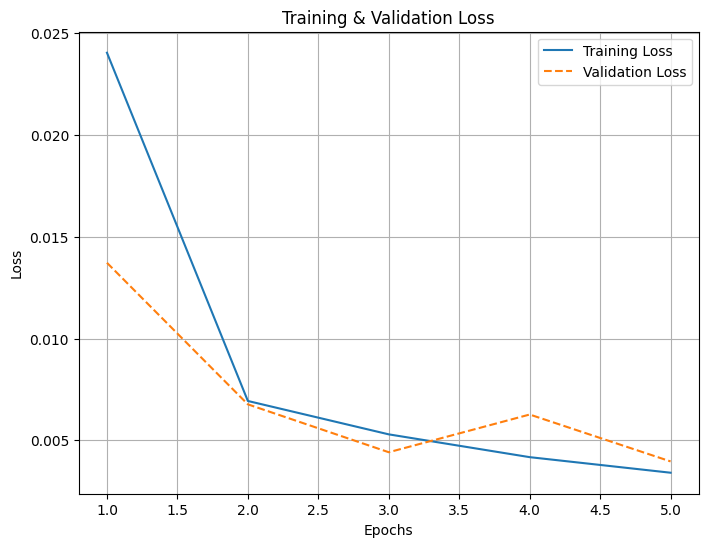

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label="Training Loss")
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

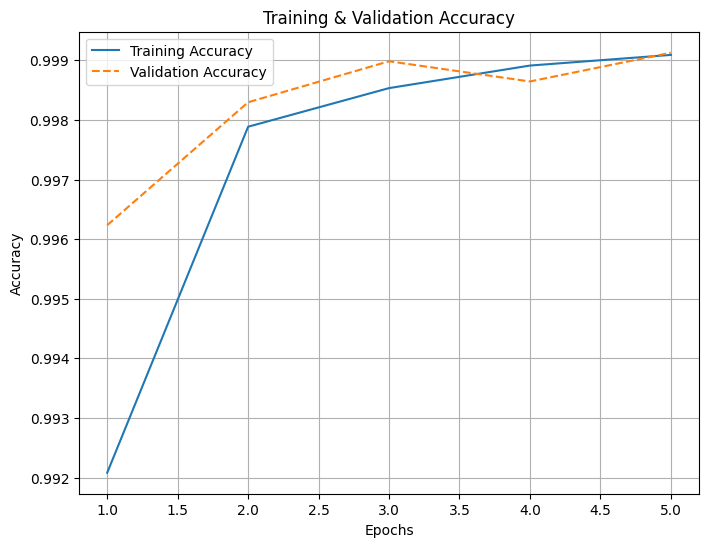

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# 測試

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0
    epoch_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)
            outputs = model(texts).squeeze()
            test_acc += ((outputs > 0.5) == labels).sum().item()
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

    test_loss = epoch_loss / len(test_loader)
    test_acc /= len(test_loader.dataset)

    return test_loss, test_acc

In [19]:
test_loss, test_acc = evaluate_model(model, test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0037, Test Accuracy: 0.9991
